In [13]:
import random
import string

def generate_messages():
    messages = []

    for _ in range(1000):
        random_string = ''.join(random.choices(string.ascii_letters, k=random.randint(5, 15)))
        encoded_string = random_string.encode('utf-8')
        messages.append(encoded_string)

    return messages

In [14]:
messages = generate_messages()

In [9]:
import struct


def rotright(value, shift):
    return (value >> shift) | (value << (32 - shift))


def ch(x, y, z):
    return (x & y) ^ (~x & z)


def maj(x, y, z):
    return (x & y) ^ (x & z) ^ (y & z)


def ep0(x):
    return rotright(x, 2) ^ rotright(x, 13) ^ rotright(x, 22)


def ep1(x):
    return rotright(x, 6) ^ rotright(x, 11) ^ rotright(x, 25)


def sig0(x):
    return rotright(x, 7) ^ rotright(x, 18) ^ (x >> 3)


def sig1(x):
    return rotright(x, 17) ^ rotright(x, 19) ^ (x >> 10)


def rotleft(value, shift):
    return (value << shift) | (value >> (32 - shift))


K = [
    0x428A2F98, 0x71374491, 0xB5C0FBCF, 0xE9B5DBA5,
    0x3956C25B, 0x59F111F1, 0x923F82A4, 0xAB1C5ED5,
    0xD807AA98, 0x12835B01, 0x243185BE, 0x550C7DC3,
    0x72BE5D74, 0x80DEB1FE, 0x9BDC06A7, 0xC19BF174,
    0xE49B69C1, 0xEFBE4786, 0xFC19DC6, 0x240CA1CC,
    0x2DE92C6F, 0x4A7484AA, 0x5CB0A9DC, 0x76F988DA,
    0x983E5152, 0xA831C66D, 0xB00327C8, 0xBF597FC7,
    0xC6E00BF3, 0xD5A79147, 0x6CA6351, 0x14292967,
    0x27B70A85, 0x2E1B2138, 0x4D2C6DFC, 0x53380D13,
    0x650A7354, 0x766A0ABB, 0x81C2C92E, 0x92722C85,
    0xA2BFE8A1, 0xA81A664B, 0xC24B8B70, 0xC76C51A3,
    0xD192E819, 0xD6990624, 0xF40E3585, 0x106AA070,
    0x19A4C116, 0x1E376C08, 0x2748774C, 0x34B0BCB5,
    0x391C0CB3, 0x4ED8AA4A, 0x5B9CCA4F, 0x682E6FF3,
    0x748F82EE, 0x78A5636F, 0x84C87814, 0x8CC70208,
     0x90BEFFFA, 0xA4506CEB, 0xBEF9A3F7, 0xC67178F2,
]


def pad_message(message):
    message_len = len(message)
    pad_len = (56 - (message_len + 1) % 64) % 64
    padded_message = message + b'\x80' + (b'\x00' * pad_len) + struct.pack('>Q', message_len * 8)
    return padded_message


def sha256(message):
    h = [
        0x6A09E667, 0xBB67AE85, 0x3C6EF372, 0xA54FF53A,
        0x510E527F, 0x9B05688C, 0x1F83D9AB, 0x5BE0CD19
    ]

    padded_message = pad_message(message)

    chunks = [padded_message[i:i + 64] for i in range(0, len(padded_message), 64)]

    for chunk in chunks:
        w = list(struct.unpack('>16L', chunk)) + [0] * 48

        for i in range(16, 64):
            s0 = sig0(w[i - 15])
            s1 = sig1(w[i - 2])
            w[i] = (w[i - 16] + s0 + w[i - 7] + s1) & 0xFFFFFFFF

        a, b, c, d, e, f, g, h = h

        for i in range(64):
            S1 = rotright(e, 6) ^ rotright(e, 11) ^ rotright(e, 25)
            ch = (e & f) ^ ((~e) & g)
            temp1 = (h + S1 + ch + K[i] + w[i]) & 0xFFFFFFFF
            S0 = rotright(a, 2) ^ rotright(a, 13) ^ rotright(a, 22)
            maj = (a & b) ^ (a & c) ^ (b & c)
            temp2 = (S0 + maj) & 0xFFFFFFFF

            h0, h1, h2, h3, h4, h5, h6, h7 = (
                (temp1 + temp2) & 0xFFFFFFFF,
                a, b, c,
                (d + temp1) & 0xFFFFFFFF,
                e, f, g
            )

    hash_value = ''.join(format(x, '08x') for x in [h0, h1, h2, h3, h4, h5, h6, h7])
    return hash_value


def md5(message):
    h0 = 0x67452301
    h1 = 0xEFCDAB89
    h2 = 0x98BADCFE
    h3 = 0x10325476

    padded_message = pad_message(message)

    chunks = [padded_message[i:i + 64] for i in range(0, len(padded_message), 64)]

    for chunk in chunks:
        a = h0
        b = h1
        c = h2
        d = h3

        x = list(struct.unpack('<16I', chunk))

        # Round 1
        s = [7, 12, 17, 22]
        for i in range(16):
            k = i
            shift = s[i % 4]
            f = (b & c) | ((~b) & d)
            temp = (a + f + k + x[i]) & 0xFFFFFFFF
            a = d
            d = c
            c = b
            b = (b + rotleft(temp, shift)) & 0xFFFFFFFF

        # Round 2
        s = [5, 9, 14, 20]
        for i in range(16):
            k = (1 + 5 * i) % 16
            shift = s[i % 4]
            f = (d & b) | (c & (~d))
            temp = (a + f + k + x[k]) & 0xFFFFFFFF
            a = d
            d = c
            c = b
            b = (b + rotleft(temp, shift)) & 0xFFFFFFFF

        # Round 3
        s = [4, 11, 16, 23]
        for i in range(16):
            k = (5 + 3 * i) % 16
            shift = s[i % 4]
            f = b ^ c ^ d
            temp = (a + f + k + x[k]) & 0xFFFFFFFF
            a = d
            d = c
            c = b
            b = (b + rotleft(temp, shift)) & 0xFFFFFFFF

        # Round 4
        s = [6, 10, 15, 21]
        for i in range(16):
            k = (7 * i) % 16
            shift = s[i % 4]
            f = c ^ (b | (~d))
            temp = (a + f + k + x[k]) & 0xFFFFFFFF
            a = d
            d = c
            c = b
            b = (b + rotleft(temp, shift)) & 0xFFFFFFFF

        h0 = (h0 + a) & 0xFFFFFFFF
        h1 = (h1 + b) & 0xFFFFFFFF
        h2 = (h2 + c) & 0xFFFFFFFF
        h3 = (h3 + d) & 0xFFFFFFFF

    hash_value = struct.pack('<4I', h0, h1, h2, h3).hex()
    return hash_value


def our_hash(message):
  sha256_hash = sha256(message)
  md5_hash = md5(message)
  combined_hash = md5_hash + sha256_hash[len(md5_hash):]
  return combined_hash


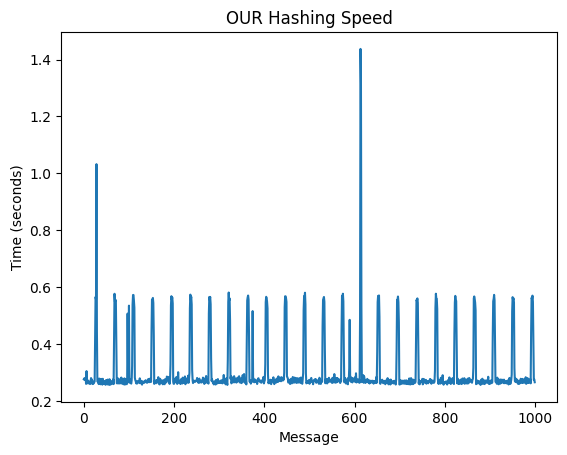

Average Hashing Speed: 3.072423665849976e-05 seconds
OUR hash size: 512 bits
No collision


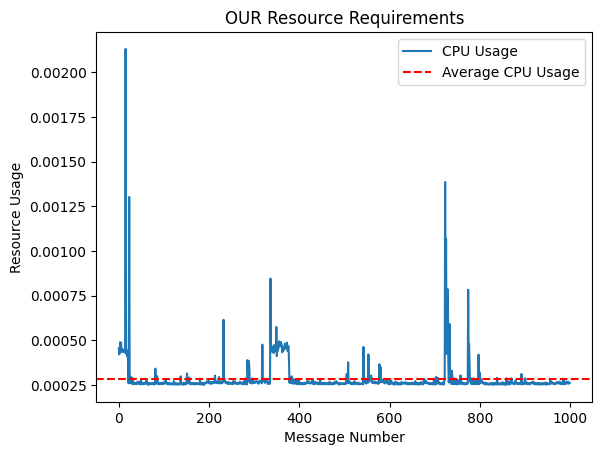

Average CPU Usage: 0.0002848217839991776


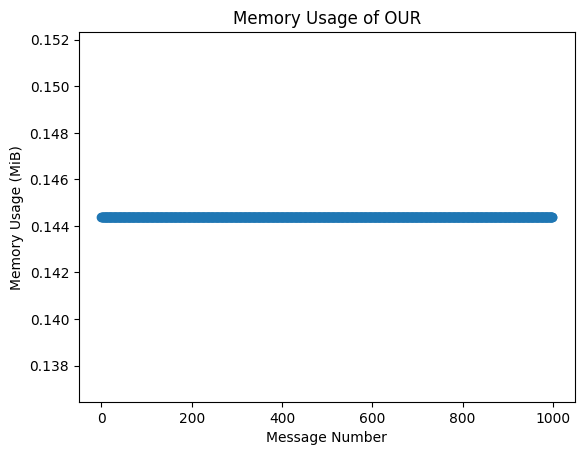

In [15]:
import timeit
import resource
import matplotlib.pyplot as plt

def test_hash_speed(messages):
    times = []

    for message in messages:
        time = timeit.timeit(lambda: our_hash(message), number=1000)
        times.append(time)

    plt.plot(range(len(messages)), times)
    plt.xlabel('Message')
    plt.ylabel('Time (seconds)')
    plt.title('OUR Hashing Speed')
    plt.show()

    total_time = sum(times)
    avg_speed = total_time / (10000 * len(messages))

    print(f"Average Hashing Speed: {avg_speed} seconds")

def test_hash_size():
    hash_size = len(our_hash(b'')) * 8
    print(f"OUR hash size: {hash_size} bits")


def test_vulnerabilities():
    # Пример атаки на коллизии
    message1 = b'message1'
    message2 = b'message2'

    hash1 = our_hash(message1)
    hash2 = our_hash(message2)

    if hash1 == hash2:
        print("Collision found")
    else:
        print("No collision")

def test_resource_requirements(messages):
    cpu_usage = []

    for i, message in enumerate(messages):
        start_time = timeit.default_timer()
        our_hash(message)
        end_time = timeit.default_timer()
        elapsed_time = end_time - start_time

        # Получить информацию о потреблении ресурсов
        cpu_usage.append(elapsed_time)

    plt.plot(range(len(cpu_usage)), cpu_usage, label='CPU Usage')
    plt.xlabel('Message Number')
    plt.ylabel('Resource Usage')
    plt.title('OUR Resource Requirements')
    plt.legend()

    average_cpu_usage = sum(cpu_usage) / len(cpu_usage)
    plt.axhline(y=average_cpu_usage, color='r', linestyle='--', label='Average CPU Usage')

    plt.legend()
    plt.show()

    print(f"Average CPU Usage: {average_cpu_usage}")

def memory_usage_of_our(messages):
    mem_usages = []
    message_numbers = list(range(len(messages)))

    for message in messages:
        start_time = timeit.default_timer()
        our_hash(message)
        end_time = timeit.default_timer()
        elapsed_time = end_time - start_time

        # Getting memory usage information
        memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024 / 1024  # Convert to MiB
        mem_usages.append(memory)

    # Plot the graph
    plt.plot(message_numbers, mem_usages, marker='o')
    plt.xlabel('Message Number')
    plt.ylabel('Memory Usage (MiB)')
    plt.title('Memory Usage of OUR')
    plt.show()


# Тестирование скорости хеширования и построение графика
test_hash_speed(messages)

# Тестирование размера хеш-функции
test_hash_size()

# Тестирование уязвимостей и атак
test_vulnerabilities()

# Тестирование требований к ресурсам и построение графика
test_resource_requirements(messages)

# Тестирование использования памяти и построение графика
memory_usage_of_our(messages)